In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from pickle import load
with open('mol_top_sys_pos.pkl', 'rb') as f:
    mol_top_sys_pos_list = load(f)

In [3]:
with open('sorted_smiles.pkl', 'rb') as f:
    smiles_list = load(f)
smiles_list[:5]

['C1[C@@H]2[C@H]3[C@@H]([C@H]1[C@H]4[C@@H]2O4)[C@@]5(C(=C([C@]3(C5(Cl)Cl)Cl)Cl)Cl)Cl',
 'C1[C@H]([C@@H]2[C@H]([C@H]1Cl)[C@]3(C(=C([C@@]2(C3(Cl)Cl)Cl)Cl)Cl)Cl)Cl',
 'C1=C[C@@H]([C@@H]2[C@H]1[C@@]3(C(=C([C@]2(C3(Cl)Cl)Cl)Cl)Cl)Cl)Cl',
 'C1[C@@H]2[C@H](COS(=O)O1)[C@@]3(C(=C([C@]2(C3(Cl)Cl)Cl)Cl)Cl)Cl',
 'CCC[N@@](CC1CC1)c2c(cc(cc2[N+](=O)[O-])C(F)(F)F)[N+](=O)[O-]']

In [4]:
n_atom_list = [len(t[-1]) for t in mol_top_sys_pos_list]

mol_index = np.argmin(n_atom_list)
smiles = smiles_list[mol_index]
smiles

'S'

In [5]:
smallest_n_atoms = min(n_atom_list)
mol_indices = [i for i in range(len(n_atom_list)) if n_atom_list[i] == smallest_n_atoms]
smiles_of_smallest_molecules = [smiles_list[mol_index] for mol_index in mol_indices]
smiles_of_smallest_molecules

['S']

In [9]:
print(sorted(list(set(n_atom_list))))

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 45]


In [12]:
for n in sorted(list(set(n_atom_list))):
    mol_indices = [i for i in range(len(n_atom_list)) if n_atom_list[i] == n]
    print('# atoms: {}'.format(n))
    print('\t' + str([smiles_list[mol_index] for mol_index in mol_indices]) + '\n')

# atoms: 3
	['S']

# atoms: 4
	['C=O', 'N']

# atoms: 5
	['C(Cl)(Cl)(Cl)Cl', 'C(F)(F)(F)Br', 'C(Br)(Br)Br', 'C(Cl)(Cl)Cl', 'C(F)(F)(F)F', 'C(F)(F)Cl', 'C(Cl)Cl', 'C(Br)Br', 'C(F)Cl', 'C(I)I', 'CCl', 'CBr', 'CF', 'CI', 'C']

# atoms: 6
	['C(=C(Cl)Cl)(Cl)Cl', 'C(=C(Cl)Cl)Cl', 'C(=C\\Cl)\\Cl', 'C(=C/Cl)\\Cl', 'C=C(Cl)Cl', 'C=CCl', 'CC#N', 'C=C', 'CS', 'NN', 'CO']

# atoms: 7
	['C([N+](=O)[O-])(Cl)(Cl)Cl', 'C[N+](=O)[O-]', 'CC(=O)O', 'CC#C', 'CC=O']

# atoms: 8
	['C(C(Cl)(Cl)Cl)(Cl)(Cl)Cl', '[C@@H](C(F)(F)F)(Cl)Br', 'C(C(F)(Cl)Cl)(F)(F)Cl', '[C@@H](C(F)(F)F)(F)Br', 'C(C(Cl)(Cl)Cl)(Cl)Cl', 'C(C(Cl)(Cl)Cl)Cl', 'C(C(Cl)Cl)(Cl)Cl', 'C(C(F)(F)F)Cl', 'C(C(Cl)Cl)Cl', 'CC(Cl)(Cl)Cl', 'CS(=O)(=O)Cl', 'C(CBr)Cl', 'CC(Cl)Cl', 'C(CBr)Br', 'C(CCl)Cl', 'CC(F)F', 'COC=O', 'CCCl', 'CCBr', 'CCI', 'CN', 'CC']

# atoms: 9
	['C(=C(F)F)(C(F)(F)F)F', 'C(C(F)(F)F)O', 'c1cnc[nH]1', 'CC(=O)N', 'c1ccsc1', 'C=CCCl', 'CCC#N', 'C1CC1', 'CC=C', 'CCO', 'CSC', 'CCS', 'COC']

# atoms: 10
	['CC[N+](=O)[O-]', 'c1cc[nH]c1', 

In [13]:
# pick one with 5 atoms and 3 distinct elements
smiles = 'C(F)(F)(F)Br'
mol_index_in_smiles_list = -1
for i in range(len(smiles_list)):
    if smiles_list[i] == smiles:
        mol_index_in_smiles_list = i
mol_index_in_smiles_list

317

In [16]:
from simtk.openmm import app
from simtk import openmm as mm
from simtk import unit
from tqdm import tqdm
from openmmtools.integrators import BAOABIntegrator

def get_nb_force(system):
    forces = sys.getForces()
    for f in forces:
        if 'NonbondedForce' in f.__class__.__name__:
            return f
    raise(Exception('No nonbonded force found'))    

def construct_gbsa_force(system):
    nb_force = get_nb_force(system)
    
    gbsa = mm.GBSAOBCForce()
    for i in range(nb_force.getNumParticles()):
        charge = nb_force.getParticleParameters(i)[0]
        gbsa.addParticle(charge=charge, radius=1.0, scalingFactor=1.0)
    return gbsa

def get_vacuum_samples(topology, system, positions, n_samples=100, thinning=10000):
    vacuum_sim = app.Simulation(topology,
                         system,
                         BAOABIntegrator(temperature=298 * unit.kelvin,
                                         collision_rate=1.0 / unit.picosecond,
                                         timestep=1.0 * unit.femtosecond,
                                         measure_heat=False,
                                         measure_shadow_work=False,
                                        ),
                         platform=mm.Platform.getPlatformByName('Reference')
                        )
    vacuum_sim.context.setPositions(positions)
    vacuum_sim.context.setVelocitiesToTemperature(298 * unit.kelvin)
    vacuum_sim.minimizeEnergy()
    vacuum_sim.step(thinning)

    vacuum_traj = []
    for _ in tqdm(range(n_samples)):
        vacuum_sim.step(thinning)
        vacuum_traj.append(vacuum_sim.context.getState(getPositions=True).getPositions(asNumpy=True))
    
    return vacuum_sim, vacuum_traj

In [17]:
mol, top, sys, pos = mol_top_sys_pos_list[mol_index_in_smiles_list]
atom_names = [a.name for a in top.atoms()]
atom_names

['C1', 'F1', 'F2', 'F3', 'Br1']

In [18]:
vacuum_sim, vacuum_traj = get_vacuum_samples(top, sys, pos, n_samples=50, thinning=50000)

100%|██████████| 50/50 [01:40<00:00,  2.01s/it]


In [19]:
from openmmtools.constants import kB
temperature = 298 * unit.kelvin
beta = 1.0 / (kB * temperature)

In [20]:
path = "../../../MSKCC/Chodera Lab/feedstock/FreeSolv-0.51/database.txt"
from pickle import load
with open(path, 'r') as f:
    freesolv = f.read()
from tqdm import tqdm
db = []
for entry in freesolv.split('\n')[3:-1]:
    db.append(entry.split('; '))

In [21]:
mol_index_in_freesolv = -1
for i in range(len(db)):
    if db[i][1] == smiles:
        mol_index_in_freesolv = i
mol_index_in_freesolv, mol_index_in_smiles_list

(502, 317)

In [36]:
db[mol_index_in_freesolv]

['mobley_7732703',
 'C(F)(F)(F)Br',
 'bromo-trifluoro-methane',
 '1.79',
 '0.60',
 '1.56',
 '0.02',
 '10.1021/ct050097l',
 '10.1021/ct800409d',
 'Experimental uncertainty not presently available, so assigned a default value.  ']

In [22]:
from simtk import unit
experimental_value = beta * (float(db[mol_index_in_freesolv][3]) * unit.kilocalorie_per_mole)
experimental_value

3.0226909312533237

In [23]:
experimental_uncertainty = beta * (float(db[mol_index_in_freesolv][4]) * unit.kilocalorie_per_mole)
experimental_uncertainty

1.0131924909229018

In [24]:
from copy import deepcopy
deepcopy(sys)

def create_implicit_sim(topology, system):
    """Implicit solvent will be force group 0, everything else will be force group 1"""
    gbsa = construct_gbsa_force(system)
    new_system = deepcopy(system)
    new_system.addForce(gbsa)
    
    implicit_sim = app.Simulation(topology,
                         new_system,
                         mm.LangevinIntegrator(298 * unit.kelvin, 1.0 / unit.picosecond, 1.0 * unit.femtosecond),
                         platform=mm.Platform.getPlatformByName('Reference')
                        )
    
    for force in implicit_sim.system.getForces():
        force.setForceGroup(1)
    
    gbsa.setForceGroup(0)

    return implicit_sim

In [25]:
def get_implicit_u_diffs(implicit_sim, x):
    u_diff = np.zeros(len(x))

    for i in range(len(x)):
        #vacuum_sim.context.setPositions(x[i])
        implicit_sim.context.setPositions(x[i])
        
        
        # TODO: test where I ensure that the force-group hackery is giving me the same as this diff
        #U_implicit = implicit_sim.context.getState(getEnergy=True).getPotentialEnergy()
        #U_vacuum = vacuum_sim.context.getState(getEnergy=True).getPotentialEnergy()
        #u_diff[i] = beta * (U_implicit - U_vacuum)
        
        
        u_diff[i] = beta * implicit_sim.context.getState(getEnergy=True, groups={0}).getPotentialEnergy()
    return u_diff

implicit_sim = create_implicit_sim(top, sys)

In [26]:
u_diffs = get_implicit_u_diffs(implicit_sim, vacuum_traj)
u_diffs

array([28.61494746, 28.2954286 , 29.00126953, 28.54677525, 28.11662005,
       28.47978896, 28.18331366, 28.25013773, 29.09561482, 28.68560536,
       28.23261082, 28.73319256, 28.20441949, 28.12033481, 28.29214669,
       28.10369167, 28.8764738 , 29.02510894, 28.74377862, 28.20024695,
       29.03232821, 28.237714  , 28.23937275, 28.37155613, 28.34173842,
       27.91434205, 28.44976254, 28.7194562 , 28.49171407, 28.9365845 ,
       28.78184612, 28.60576647, 28.20674718, 28.67918842, 28.63538948,
       28.24707499, 28.52903145, 28.21925794, 28.19898542, 28.79098565,
       28.85977335, 28.95937214, 28.28898619, 28.0501597 , 27.96725818,
       28.50983341, 28.29197758, 28.41713506, 28.61105356, 28.5167557 ])

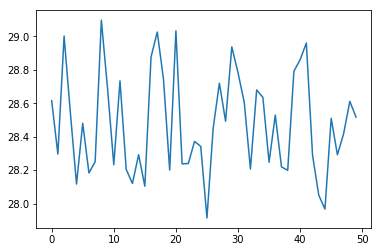

In [27]:
plt.plot(u_diffs)

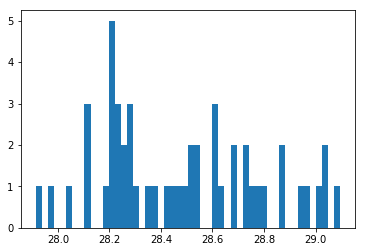

In [28]:
plt.hist(u_diffs, bins=50);

Text(0,0.5,'estimated $\\Delta F$')

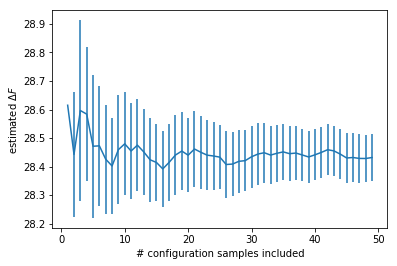

In [29]:
import pymbar
means, uncs = [], []
for i in range(1, len(u_diffs)):
    mean, unc = pymbar.EXP(u_diffs[:i])
    means.append(mean)
    uncs.append(unc)
means = np.array(means)
uncs = np.array(uncs)

plt.errorbar(range(1, 1 + len(means)), means, 1.96 * uncs)
plt.xlabel('# configuration samples included')
plt.ylabel(r'estimated $\Delta F$')

In [30]:
def get_gbsa_force(system):
    for force in system.getForces():
        if "GBSA" in force.__class__.__name__:
            return force
    raise(Exception('No GBSA force found'))
    
def predict_solvation_free_energy(theta):
    radii, scaling_factors = theta[:int(len(theta) / 2)], theta[int(len(theta) / 2):]
    gbsa = get_gbsa_force(implicit_sim.context.getSystem())
    
    for i in range(len(radii)):
        charge = gbsa.getParticleParameters(i)[0]
        gbsa.setParticleParameters(index=i,
                                   charge=charge,
                                   radius=radii[i],
                                   scalingFactor=scaling_factors[i],
                                  )
    
    gbsa.updateParametersInContext(implicit_sim.context)
    u_diffs = get_implicit_u_diffs(implicit_sim, vacuum_traj)
    mean, unc = pymbar.EXP(u_diffs)
    
    return mean, unc

def log_likelihood_with_predictive_uncertainty(theta):
    """theta includes radii and scaling factors"""

    mean, unc = predict_solvation_free_energy(theta)
    
    return - (mean - experimental_value)**2 / (unc * experimental_uncertainty)

def log_likelihood(theta):
    """ignore predictive uncertainty"""

    mean, unc = predict_solvation_free_energy(theta)
    
    return - (mean - experimental_value)**2 / (experimental_uncertainty**2)

def log_prior(theta):
    '''uniform in [0, 10]^d'''
    if (np.min(theta) <= 0) or (np.max(theta) >= 10):
        return - np.inf
    else:
        return 0

def log_prob(theta):
    return log_prior(theta) + log_likelihood(theta)

theta0 = np.ones(len(pos) * 2)

In [31]:
theta0, theta0.shape

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), (10,))

In [33]:
%%time
log_likelihood(theta0)

CPU times: user 4.44 ms, sys: 451 µs, total: 4.89 ms
Wall time: 4.47 ms


-628.9980277426101

In [34]:
def random_walk_mh(x0, log_prob_fun, n_steps=1000, stepsize=0.1):
    
    dim = len(x0)
    
    traj = [x0]
    log_probs = [log_prob_fun(x0)]
    
    acceptances = 0
    r = range(n_steps)
    trange = tqdm(r)
    #for n in r:
    for n in trange:
        
        x_proposal = traj[-1] + stepsize * np.random.randn(dim)
        log_prob_proposal = log_prob_fun(x_proposal)
        
        if np.random.rand() < np.exp(log_prob_proposal - log_probs[-1]):
            traj.append(x_proposal)
            log_probs.append(log_prob_proposal)
            acceptances += 1
        else:
            traj.append(traj[-1])
            log_probs.append(log_probs[-1])
        
        trange.set_postfix({'log_prob': log_probs[-1], 'accept_fraction': float(acceptances) / (1 + n)})
    del(trange)
    
    return np.array(traj), np.array(log_probs), float(acceptances) / n_steps

In [35]:
import pyemma

In [37]:
from corner import corner

In [38]:
def log_prob_with_predictive_uncertainty(theta):
    return log_prior(theta) + log_likelihood_with_predictive_uncertainty(theta)

In [ ]:
# question: can I just parameterize the radii and hold the scale factors constant?
# maybe we should modify log_prob_with_predictive_uncertainty to include some additive constant

In [39]:
def predict_solvation_free_energy_from_radii(radii, scaling_factor=1):
    gbsa = get_gbsa_force(implicit_sim.context.getSystem())
    
    for i in range(len(radii)):
        charge = gbsa.getParticleParameters(i)[0]
        gbsa.setParticleParameters(index=i,
                                   charge=charge,
                                   radius=radii[i],
                                   scalingFactor=scaling_factor,
                                  )
    
    gbsa.updateParametersInContext(implicit_sim.context)
    u_diffs = get_implicit_u_diffs(implicit_sim, vacuum_traj)
    mean, unc = pymbar.EXP(u_diffs)
    
    return mean, unc

def log_likelihood_with_predictive_uncertainty_from_radii(radii):
    mean, unc = predict_solvation_free_energy_from_radii(radii)
    return - (mean - experimental_value)**2 / (unc * experimental_uncertainty)

def log_prob_radii(radii):
    return log_prior(radii) + log_likelihood_with_predictive_uncertainty_from_radii(radii)

radii0 = np.ones(len(pos))
radii0, radii0.shape

(array([1., 1., 1., 1., 1.]), (5,))

In [40]:
traj, log_probs, acceptance_fraction = random_walk_mh(radii0, log_prob_radii,
                                                      n_steps=1000, stepsize=0.01)
acceptance_fraction

100%|██████████| 1000/1000 [00:06<00:00, 153.55it/s, log_prob=-0.025, accept_fraction=0.179]  


0.179

In [41]:
radii1 = traj[-1]

In [42]:
# question / suspicion: when I hold the scalingFactor fixed, will I still estimate radii (0.1,0.5,2) (which corresponded to scalingFactors (7,10,0.3))

In [51]:
traj, log_probs, acceptance_fraction = random_walk_mh(radii1, log_prob_radii,
                                                      n_steps=100000, stepsize=0.0025)
acceptance_fraction

100%|██████████| 100000/100000 [10:32<00:00, 158.15it/s, log_prob=-0.123, accept_fraction=0.349]  


0.34943

In [ ]:
# should also plot the element radii as lines

In [55]:
atom_names = [a.element.name for a in top.atoms()]
atom_names

['carbon', 'fluorine', 'fluorine', 'fluorine', 'bromine']

In [56]:
traj.shape

(100001, 5)

In [ ]:
plt.

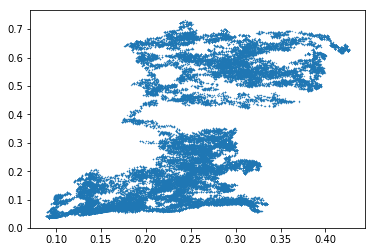

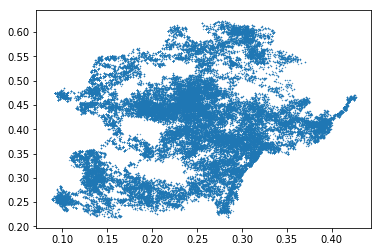

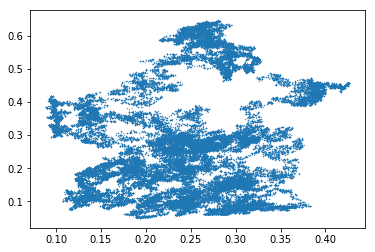

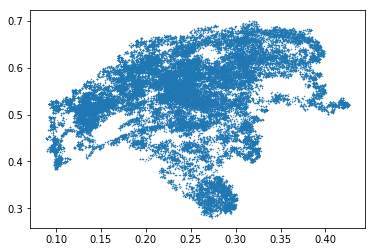

In [59]:
plt.scatter(traj[:,0], traj[:,1], s=0.1)
plt.figure()
plt.scatter(traj[:,0], traj[:,2], s=0.1)
plt.figure()
plt.scatter(traj[:,0], traj[:,3], s=0.1)
plt.figure()
plt.scatter(traj[:,0], traj[:,4], s=0.1)

In [60]:
posterior_predictions = [predict_solvation_free_energy_from_radii(r)[0] for r in traj[::100]]

/Users/joshuafass/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


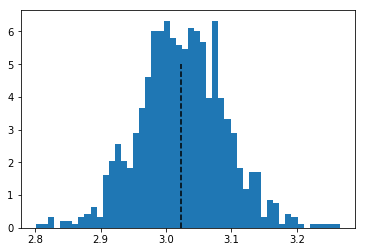

In [61]:
plt.hist(posterior_predictions, bins=50, normed=True);
plt.vlines(experimental_value, 0, 5, linestyles='--')

In [62]:
extended_traj, log_probs, acceptance_fraction = random_walk_mh(traj[-1], log_prob_radii,
                                                      n_steps=1000000, stepsize=0.005)
acceptance_fraction

 56%|█████▌    | 555467/1000000 [1:35:10<1:16:09, 97.27it/s, log_prob=-0.562, accept_fraction=0.163]   /Users/joshuafass/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
100%|██████████| 1000000/1000000 [2:27:49<00:00, 112.74it/s, log_prob=-0.87, accept_fraction=0.189]    


0.189334

In [63]:
np.save('radii_samples_at_scaling_factor_1_{}.npy'.format(smiles), extended_traj)

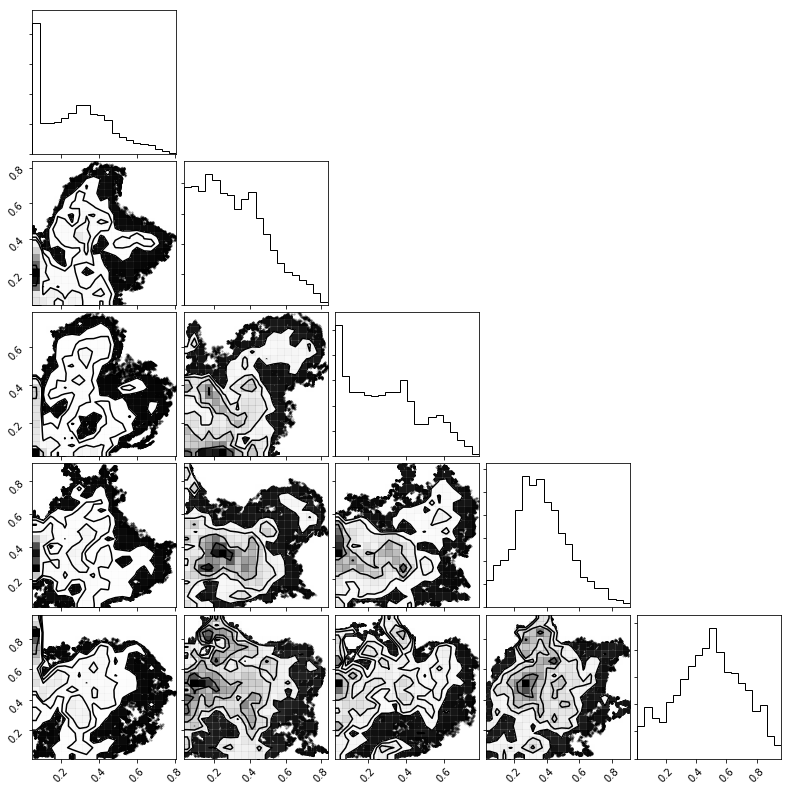

In [64]:
_ = corner(extended_traj)

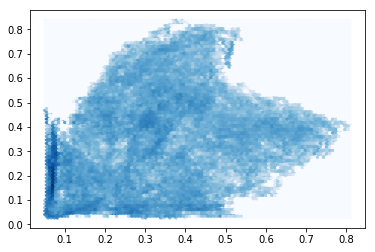

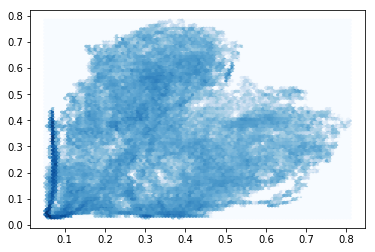

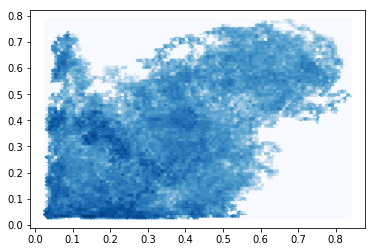

In [65]:
plt.hexbin(extended_traj[:,0], extended_traj[:,1], bins='log', cmap='Blues')
plt.figure()
plt.hexbin(extended_traj[:,0], extended_traj[:,2], bins='log', cmap='Blues')
plt.figure()
plt.hexbin(extended_traj[:,1], extended_traj[:,2], bins='log', cmap='Blues')

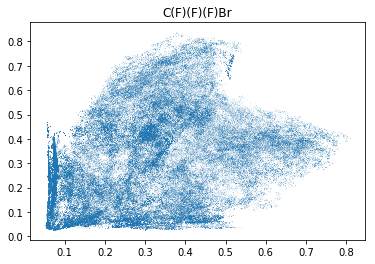

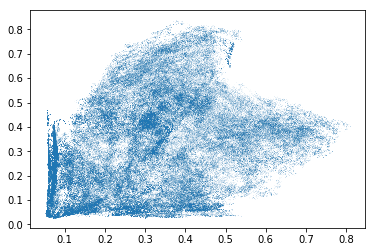

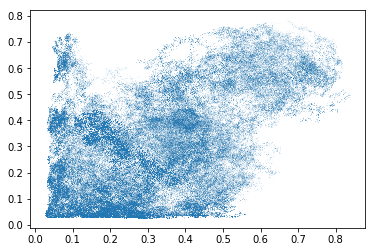

In [68]:
plt.scatter(extended_traj[:,0], extended_traj[:,1], s=0.01, alpha=0.1)
plt.title(smiles)
plt.figure()
plt.scatter(extended_traj[:,0], extended_traj[:,1], s=0.01, alpha=0.1)
plt.figure()
plt.scatter(extended_traj[:,1], extended_traj[:,2], s=0.01, alpha=0.1)

In [67]:
len(pos)

5

In [69]:
np.min(extended_traj, 0)

array([0.05193868, 0.02690981, 0.02656809, 0.02778023, 0.01316619])

In [70]:
np.max(extended_traj, 0)

array([0.80829858, 0.83721638, 0.78336302, 0.91038618, 0.96158419])